# 02 - Entrenamiento del Transformer

Este notebook documenta el pipeline de entrenamiento del TransformerV3.

**Nota**: El entrenamiento real se ejecuta con `python run_training.py` desde la terminal
(requiere GPU, ~30 min por fase). Este notebook sirve como referencia y documentación.


**Arquitectura**: TransformerV3 con Answer Head, BPE (4000 tokens), ~10.5M parámetros.**Estrategia**: Entrenamiento en 3 fases para resolver colapso de cross-attention.


In [15]:
import os
import sys
import json
import numpy as np
import tensorflow as tf

# Agregar directorio raíz al path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Agregar directorio padre para imports del paquete
parent_dir = os.path.dirname(project_root)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
print(f"Directorio del proyecto: {project_root}")

TensorFlow version: 2.20.0
GPU disponible: []
Directorio del proyecto: /home/melissa/transformer_math_physics_tutor


## 1. Importar Módulos del Proyecto

In [ ]:
from transformer_math_physics_tutor.data.subword_tokenizer import SubwordTokenizer
from transformer_math_physics_tutor.data.dataset_builder import create_datasets_v3_easy
from transformer_math_physics_tutor.models.config import TransformerConfig
from transformer_math_physics_tutor.models.transformer_v3 import TransformerV3
from transformer_math_physics_tutor.training.trainer import TransformerTrainerV3
from transformer_math_physics_tutor.training.scheduler import CustomSchedule

print("Todos los módulos importados correctamente (v3).")

Todos los módulos importados correctamente.


## 2. Cargar Datos y Tokenizer BPE

In [ ]:
# Dataset actual: combined_easy.json (6,881 problemas)
data_dir = os.path.join(project_root, 'data')
data_file = os.path.join(data_dir, 'combined_easy.json')

if not os.path.exists(data_file):
    raise FileNotFoundError(f"No se encontró {data_file}. Asegúrese de tener el dataset.")

with open(data_file, 'r', encoding='utf-8') as f:
    problems = json.load(f)

print(f"Dataset cargado: {len(problems)} problemas")

# Contar por split y dominio
from collections import Counter
splits = Counter(p.get('split', 'unknown') for p in problems)
domains = Counter(p.get('domain', 'unknown') for p in problems)
print(f"  Splits: {dict(splits)}")
print(f"  Dominios: {dict(domains)}")

Usando dataset MATH: /home/melissa/transformer_math_physics_tutor/data/math_clean.json
Problemas cargados: 1581


In [ ]:
# Cargar tokenizer BPE entrenado
tokenizer_path = os.path.join(project_root, 'checkpoints', 'v3_easy', 'sp_tokenizer.model')

tokenizer = SubwordTokenizer()
tokenizer.load_vocab(tokenizer_path)

print(f"\nTokenizer BPE cargado:")
print(f"  Vocab size: {tokenizer.vocab_size}")
print(f"  Tokens especiales: PAD={tokenizer.pad_token_id}, START={tokenizer.start_token_id}, END={tokenizer.end_token_id}, UNK={tokenizer.unk_token_id}")

# Test rápido
test_text = problems[0]['problem'][:80]
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\nTest: '{test_text}'")
print(f"  Encoded ({len(encoded)} tokens): {encoded[:15]}...")
print(f"  Decoded: '{decoded}'")

Vocabulario construido: 97 tokens (93 caracteres + 4 especiales)

Tokenizer creado:
  Vocab size: 97
  Tokens especiales: PAD=0, START=1, END=2, UNK=3
Vocabulario guardado en /home/melissa/transformer_math_physics_tutor/checkpoints/vocab.json (97 tokens)

Test: 'The temperature in a desert rose 1.5 degrees in 15'
  Encoded (52 tokens): [1, 57, 76, 73, 5, 88, 73, 81, 84, 73, 86, 69, 88, 89, 86]...
  Decoded: 'The temperature in a desert rose 1.5 degrees in 15'
  Match: True


## 3. Crear Datasets de Entrenamiento y Validación

In [21]:
# Parámetros
MAX_ENCODER_LEN = 100  # Máx longitud problema (en tokens/caracteres)
MAX_DECODER_LEN = 150  # Máx longitud solución
BATCH_SIZE = 16
VAL_SPLIT = 0.1

# Crear datasets
train_dataset, val_dataset, tokenizer = create_train_val_datasets(
    data_file=data_file,
    tokenizer=tokenizer,
    max_problem_len=MAX_ENCODER_LEN,
    max_solution_len=MAX_DECODER_LEN,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    build_vocab=False  # Ya construimos el vocab
)

# Inspeccionar un batch
for (enc, dec), target in train_dataset.take(1):
    print(f"\nBatch de ejemplo:")
    print(f"  Encoder input: {enc.shape}")
    print(f"  Decoder input: {dec.shape}")
    print(f"  Target: {target.shape}")


División train/val: 1423/158

Creando dataset de entrenamiento:
  Secuencias preparadas: 1423
  Shape encoder_inputs: (1423, 100)
  Shape decoder_inputs: (1423, 150)
  Shape decoder_targets: (1423, 150)

Creando dataset de validación:
  Secuencias preparadas: 158
  Shape encoder_inputs: (158, 100)
  Shape decoder_inputs: (158, 150)
  Shape decoder_targets: (158, 150)

Batch de ejemplo:
  Encoder input: (16, 100)
  Decoder input: (16, 150)
  Target: (16, 150)


## 4. Configurar e Instanciar el Modelo

In [23]:
# Configuración del modelo
config = TransformerConfig(
    d_model=128,
    num_heads=4,
    num_layers=2,
    dff=256,
    dropout_rate=0.1,
    max_encoder_len=MAX_ENCODER_LEN + 10,  # +10 por tokens especiales
    max_decoder_len=MAX_DECODER_LEN + 10,
    vocab_size=tokenizer.vocab_size,
    warmup_steps=500,
    epochs=500,
    batch_size=BATCH_SIZE
)

print(config)

# Guardar configuración
config_path = os.path.join(project_root, 'checkpoints', 'config.json')
config.save(config_path)

TransformerConfig(d_model=128, num_heads=4, num_layers=2, dff=256, dropout_rate=0.1, max_encoder_len=110, max_decoder_len=160, vocab_size=97, warmup_steps=500, label_smoothing=0.1, epochs=500, batch_size=16, checkpoint_dir=checkpoints)
Configuración guardada en /home/melissa/transformer_math_physics_tutor/checkpoints/config.json


In [24]:
# Instanciar modelo
model = Transformer(config)

# Forward pass dummy para construir el modelo
dummy_enc = tf.zeros((1, 10), dtype=tf.int32)
dummy_dec = tf.zeros((1, 10), dtype=tf.int32)
_ = model((dummy_enc, dummy_dec), training=False)

# Resumen
print(f"\nModelo creado exitosamente.")
print(f"Total de parámetros: {model.count_params():,}")
model.summary()

/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_2' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_3' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_1' (of type Encoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  war


Modelo creado exitosamente.
Total de parámetros: 699,873


Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │       277,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │       409,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (1, 10, 97)            │        12,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,873 (2.67 MB)

 Trainable params: 699,873 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenar el Modelo

In [25]:
# Crear trainer
trainer = TransformerTrainer(model, config)

print("Trainer creado.")
print(f"  Optimizer: Adam (β1=0.9, β2=0.98)")
print(f"  LR Schedule: CustomSchedule (d_model={config.d_model}, warmup={config.warmup_steps})")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")

Trainer creado.
  Optimizer: Adam (β1=0.9, β2=0.98)
  LR Schedule: CustomSchedule (d_model=128, warmup=500)
  Checkpoint dir: /home/melissa/transformer_math_physics_tutor/checkpoints


In [26]:
# Entrenar
EPOCHS = 500

history = trainer.train(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=EPOCHS,
    checkpoint_every=5,
    verbose=True
)

Checkpoint restaurado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-29

Iniciando entrenamiento por 500 épocas...
Dispositivo: CPU
------------------------------------------------------------


  Época 1, Batch 50: Loss=3.0849, Acc=0.3195
Época 1/500 — Loss: 2.9110 — Acc: 0.3518 — Val_Loss: 2.5495 — Val_Acc: 0.4341 — LR: 0.001147 — Tiempo: 15.2s
  Época 2, Batch 50: Loss=2.5526, Acc=0.4172
Época 2/500 — Loss: 2.5693 — Acc: 0.4116 — Val_Loss: 2.4896 — Val_Acc: 0.4486 — LR: 0.001138 — Tiempo: 6.2s
  Época 3, Batch 50: Loss=2.5403, Acc=0.4220
Época 3/500 — Loss: 2.5163 — Acc: 0.4225 — Val_Loss: 2.4653 — Val_Acc: 0.4673 — LR: 0.001130 — Tiempo: 6.2s
  Época 4, Batch 50: Loss=2.4528, Acc=0.4330
Época 4/500 — Loss: 2.4637 — Acc: 0.4280 — Val_Loss: 2.4849 — Val_Acc: 0.4288 — LR: 0.001122 — Tiempo: 6.2s
  Época 5, Batch 50: Loss=2.4354, Acc=0.4337
Época 5/500 — Loss: 2.4394 — Acc: 0.4326 — Val_Loss: 2.4552 — Val_Acc: 0.4687 — LR: 0.001114 — Tiempo: 6.4s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-30
  Época 6, Batch 50: Loss=2.3773, Acc=0.4479
Época 6/500 — Loss: 2.3891 — Acc: 0.4484 — Val_Loss: 2.4603 — Val_Acc: 0.4535 — LR: 0.001106 — Tiem

2026-02-13 23:50:14.151286: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 11/500 — Loss: 2.2879 — Acc: 0.4686 — Val_Loss: 2.4644 — Val_Acc: 0.4540 — LR: 0.001070 — Tiempo: 6.3s
  Época 12, Batch 50: Loss=2.2411, Acc=0.4776
Época 12/500 — Loss: 2.2545 — Acc: 0.4755 — Val_Loss: 2.4413 — Val_Acc: 0.4613 — LR: 0.001063 — Tiempo: 6.4s
  Época 13, Batch 50: Loss=2.2134, Acc=0.4863
Época 13/500 — Loss: 2.2465 — Acc: 0.4760 — Val_Loss: 2.4518 — Val_Acc: 0.4394 — LR: 0.001056 — Tiempo: 6.3s
  Época 14, Batch 50: Loss=2.2163, Acc=0.4909
Época 14/500 — Loss: 2.2263 — Acc: 0.4840 — Val_Loss: 2.4607 — Val_Acc: 0.4607 — LR: 0.001049 — Tiempo: 6.2s
  Época 15, Batch 50: Loss=2.1983, Acc=0.4938
Época 15/500 — Loss: 2.2174 — Acc: 0.4889 — Val_Loss: 2.4892 — Val_Acc: 0.4514 — LR: 0.001043 — Tiempo: 6.2s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-32
  Época 16, Batch 50: Loss=2.1825, Acc=0.4850
Época 16/500 — Loss: 2.1744 — Acc: 0.4936 — Val_Loss: 2.4952 — Val_Acc: 0.4453 — LR: 0.001036 — Tiempo: 6.4s
  Época 17, Batch 50: Loss

## 6. Guardar el Modelo

In [28]:
# Guardar pesos del modelo
trainer.save_model()

# Guardar vocabulario del tokenizer en checkpoints
tokenizer.save_vocab(os.path.join(project_root, 'checkpoints', 'vocab.json'))

# Guardar configuración
config.save(os.path.join(project_root, 'checkpoints', 'config.json'))

print("\nTodo guardado:")
print(f"  - Pesos del modelo: checkpoints/")
print(f"  - Vocabulario: checkpoints/vocab.json")
print(f"  - Configuración: checkpoints/config.json")

Pesos del modelo guardados en /home/melissa/transformer_math_physics_tutor/checkpoints/model_weights.weights.h5
Vocabulario guardado en /home/melissa/transformer_math_physics_tutor/checkpoints/vocab.json (97 tokens)
Configuración guardada en /home/melissa/transformer_math_physics_tutor/checkpoints/config.json

Todo guardado:
  - Pesos del modelo: checkpoints/
  - Vocabulario: checkpoints/vocab.json
  - Configuración: checkpoints/config.json


## 7. Curvas de Entrenamiento

In [30]:
def plot_text_curve(values, title, ylabel, width=60):
    """Visualiza una curva de entrenamiento con texto."""
    if not values:
        print(f"Sin datos para {title}")
        return
    
    min_val = min(values)
    max_val = max(values)
    val_range = max_val - min_val if max_val != min_val else 1
    
    print(f"\n{title}")
    print(f"{ylabel}: [{min_val:.4f}, {max_val:.4f}]")
    print('─' * (width + 15))
    
    for i, val in enumerate(values):
        bar_len = int((val - min_val) / val_range * width)
        bar = '█' * max(bar_len, 1)
        print(f"  E{i+1:3d} | {bar} {val:.4f}")

# Graficar curvas
plot_text_curve(history['train_loss'], 'Training Loss', 'Loss')
plot_text_curve(history['train_accuracy'], 'Training Accuracy', 'Accuracy')

if history.get('val_loss'):
    plot_text_curve(history['val_loss'], 'Validation Loss', 'Loss')
    plot_text_curve(history['val_accuracy'], 'Validation Accuracy', 'Accuracy')

plot_text_curve(history['learning_rates'], 'Learning Rate', 'LR')


Training Loss
Loss: [0.8008, 2.9110]
───────────────────────────────────────────────────────────────────────────
  E  1 | ████████████████████████████████████████████████████████████ 2.9110
  E  2 | ██████████████████████████████████████████████████ 2.5693
  E  3 | ████████████████████████████████████████████████ 2.5163
  E  4 | ███████████████████████████████████████████████ 2.4637
  E  5 | ██████████████████████████████████████████████ 2.4394
  E  6 | █████████████████████████████████████████████ 2.3891
  E  7 | ████████████████████████████████████████████ 2.3657
  E  8 | ███████████████████████████████████████████ 2.3454
  E  9 | ███████████████████████████████████████████ 2.3240
  E 10 | ██████████████████████████████████████████ 2.2882
  E 11 | ██████████████████████████████████████████ 2.2879
  E 12 | █████████████████████████████████████████ 2.2545
  E 13 | █████████████████████████████████████████ 2.2465
  E 14 | ████████████████████████████████████████ 2.2263
  E 15 | ███████

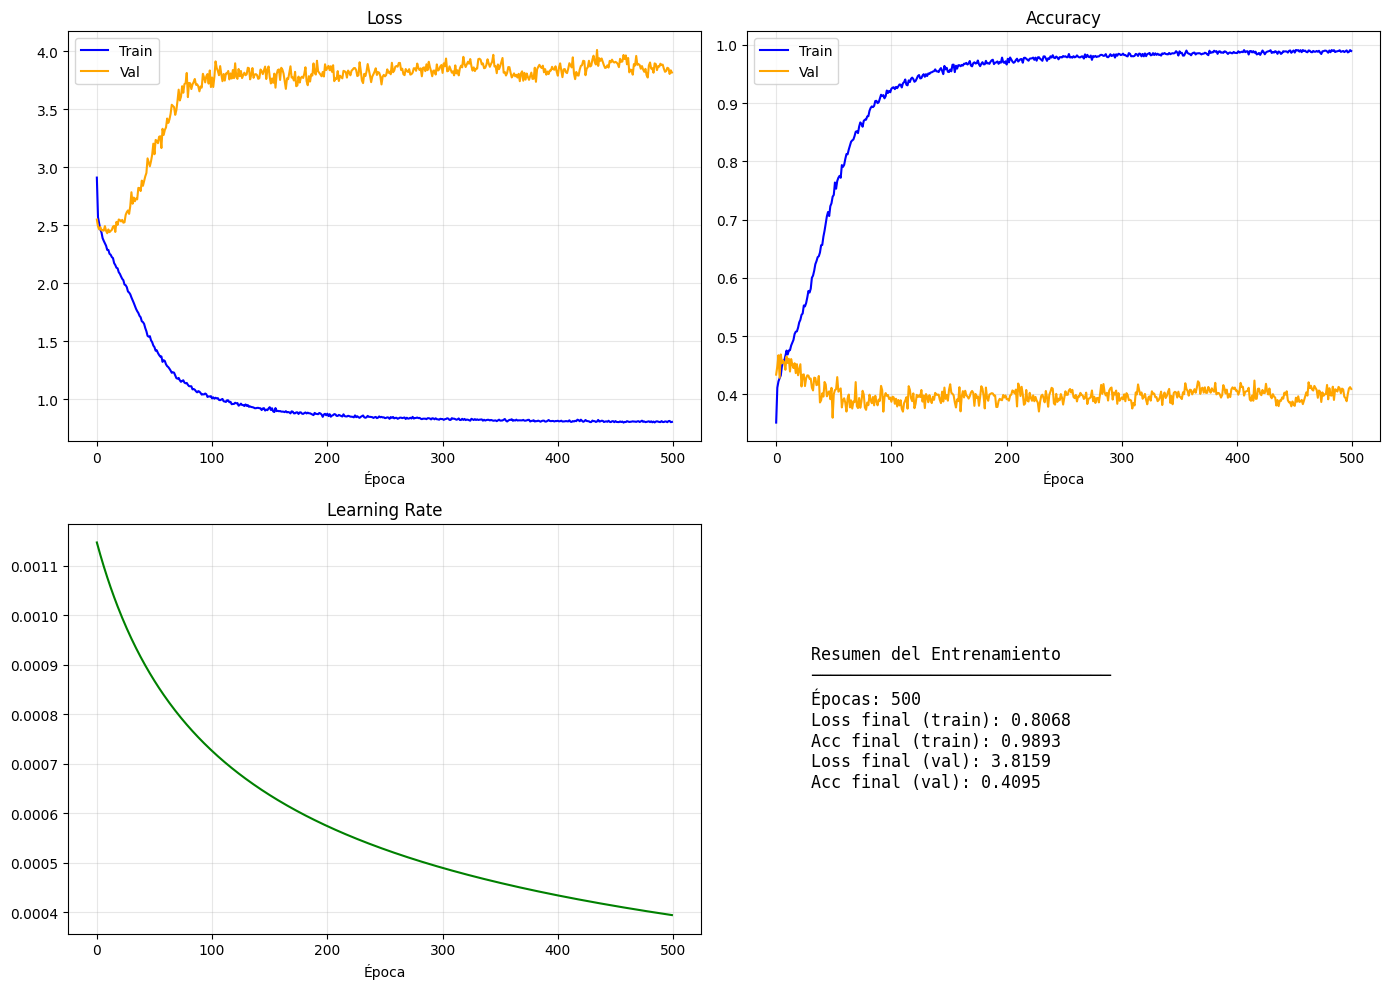

Gráficas guardadas en checkpoints/training_curves.png


In [31]:
# Intentar graficar con matplotlib si está disponible
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', color='blue')
    if history.get('val_loss'):
        axes[0, 0].plot(history['val_loss'], label='Val', color='orange')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_accuracy'], label='Train', color='blue')
    if history.get('val_accuracy'):
        axes[0, 1].plot(history['val_accuracy'], label='Val', color='orange')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Resumen final
    axes[1, 1].axis('off')
    summary_text = (
        f"Resumen del Entrenamiento\n"
        f"{'─'*30}\n"
        f"Épocas: {len(history['train_loss'])}\n"
        f"Loss final (train): {history['train_loss'][-1]:.4f}\n"
        f"Acc final (train): {history['train_accuracy'][-1]:.4f}\n"
    )
    if history.get('val_loss'):
        summary_text += (
            f"Loss final (val): {history['val_loss'][-1]:.4f}\n"
            f"Acc final (val): {history['val_accuracy'][-1]:.4f}\n"
        )
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                    verticalalignment='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, 'checkpoints', 'training_curves.png'), dpi=150)
    plt.show()
    print("Gráficas guardadas en checkpoints/training_curves.png")
    
except ImportError:
    print("matplotlib no disponible. Usa las gráficas de texto anteriores.")
    print("Instalar con: pip install matplotlib")